In [1]:
import re
import pandas as pd

LOG_PATH = '../data/logfiles.log'
LOG_PATTERN = r'(?P<ip>\S+) - - \[(?P<time>[^\]]+)\] "(?P<method>\S+) (?P<endpoint>\S+) HTTP/\d\.\d" (?P<status>\d+) (?P<bytes>\d+) "(?P<referrer>[^"]+)" "(?P<ua>[^"]+)" (?P<response_time>\d+)'

def drop_data(df):
    """
    Drop unnesscary data
    
    It's all the same
    """
    return df.drop(["time", "referrer"], axis=1)

def parse_logs(path):
    data = []
    with open(path) as f:
        for line in f:
            match = re.match(LOG_PATTERN, line)
            if match:
                data.append(match.groupdict())
    
    return drop_data(pd.DataFrame(data))

df = parse_logs(LOG_PATH)
df.head()


,ip,method,endpoint,status,bytes,ua,response_time
0,78.227.234.134,GET,/usr,304,4944,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3)...,713
1,8.108.176.251,DELETE,/usr,303,5350,Mozilla/5.0 (Linux; Android 10; ONEPLUS A6000)...,1906
2,3.173.150.154,GET,/usr/register,404,4835,Mozilla/5.0 (Linux; Android 10; ONEPLUS A6000)...,3680
3,116.115.120.25,PUT,/usr,200,4240,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2788
4,160.26.158.113,PUT,/usr/admin,404,5436,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,793


In [2]:
from user_agents import parse
method_map = {
    "GET": 0,
    "DELETE": 1,
    "PUT": 2,
    "POST": 3
}
method_map2 = {
    "/usr": 0,
    "/usr/register": 1,
    "/usr/admin": 2,
    "/usr/admin/developer": 3,
    "/usr/login": 4
}
ua_parsed = df["ua"].apply(parse)
df["os"] = ua_parsed.apply(lambda x: x.os.family)
df["device"] = ua_parsed.apply(lambda x: x.device.family)
df["browser"] = ua_parsed.apply(lambda x: x.browser.family)
df["request_type_dummy"] = df["method"].map(method_map)
df["endpoint_dummy"] = df["endpoint"].map(method_map2)
df["status"] = df["status"].astype(int)
df["is_error"] = (df["status"] >= 400).astype(int)

In [ ]:
os_dummies = pd.get_dummies(df['os'], prefix='os', drop_first=True).astype(int)
device_dummies = pd.get_dummies(df['device'], prefix='d', drop_first=True).astype(int)
browser_dummies = pd.get_dummies(df['browser'], prefix='b', drop_first=True).astype(int)

In [4]:
import random
import numpy as np
def data_set_creation(df):
    random.seed(42)
    np.random.seed(42)
    df = pd.concat([df, os_dummies, device_dummies, browser_dummies], axis=1)

    df["response_time"] = (
    df["bytes"].astype(int) // 11 +
    df["request_type_dummy"].astype(int) * np.random.normal(25, 25, len(df)) +
    df["endpoint_dummy"].astype(int) * 15 +
    df["os_Mac OS X"] * np.random.normal(80, 10, len(df)) +
    df["os_Windows"] * np.random.normal(90, 10, len(df)) +
    
    df["d_Mac"] * np.random.normal(100, 15, len(df)) +
    df["d_iPhone"] * np.random.normal(120, 20, len(df)) +
    df["d_Other"] * -np.random.normal(160, 20, len(df)) +

    df["b_Chrome Mobile"] * np.random.normal(75, 15, len(df)) +
    df["b_Edge"] * np.random.normal(195, 25, len(df)) +
    df["b_Edge Mobile"] * -np.random.normal(165, 25, len(df)) +
    df["b_Opera"] * np.random.normal(90, 15, len(df)) +
    df["b_Safari"] * np.random.normal(110, 20, len(df)) +
    
    df["b_Opera Mobile"] * -90 +
    df["request_type_dummy"].astype(int)*df["endpoint_dummy"].astype(int)*25 + 
    np.random.normal(0, 100, len(df))  # extra general noise
    )
        
    return df

In [5]:
new_data = data_set_creation(df)

In [6]:
new_data.columns
new_data = new_data.drop(["ip", "method", "endpoint", "ua", "os", "device", "browser", "status"], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = new_data[["bytes", "request_type_dummy", "endpoint_dummy"]]
y = new_data["response_time"]
X = pd.concat([X, os_dummies, browser_dummies, device_dummies], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(max_depth=10, random_state=0)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE:  {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f}")
print(f"R²:   {r2_score(y_test, y_pred):.2f}")

MAE:  96.07
MSE:  14714.68
RMSE: 121.30
R²:   0.68


In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),  # step=1 by default
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
    }

    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)

    score = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=3)
    return -score.mean()

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50) 

[I 2025-05-21 00:17:29,938] A new study created in memory with name: no-name-2c373162-4543-4c27-89f3-a00a4a5184da
[I 2025-05-21 00:17:30,887] Trial 0 finished with value: 19911.522738466323 and parameters: {'n_estimators': 210, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 19911.522738466323.
[I 2025-05-21 00:17:31,737] Trial 1 finished with value: 30507.151034337967 and parameters: {'n_estimators': 191, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 19911.522738466323.
[I 2025-05-21 00:17:32,891] Trial 2 finished with value: 14742.820687772226 and parameters: {'n_estimators': 261, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 14742.820687772226.
[I 2025-05-21 00:17:33,597] Trial 3 finished with value: 13970.917813520347 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min

In [ ]:
best_params = study.best_params
print("Best parameters:", best_params)

final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

Best parameters: {'n_estimators': 221, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt'}


In [ ]:
import json
with open("best_params.json", "w") as w:
    json.dump(best_params, w)

In [ ]:
model_best = RandomForestRegressor(n_estimators=221, max_depth=16, min_samples_split=5, min_samples_leaf=8, max_features="sqrt")
model_best.fit(X_train, y_train)

y_pred = model_best.predict(X_test)

print(f"MAE:  {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE:  {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f}")
print(f"R²:   {r2_score(y_test, y_pred):.2f}")

MAE:  92.51
MSE:  13732.09
RMSE: 117.18
R²:   0.70


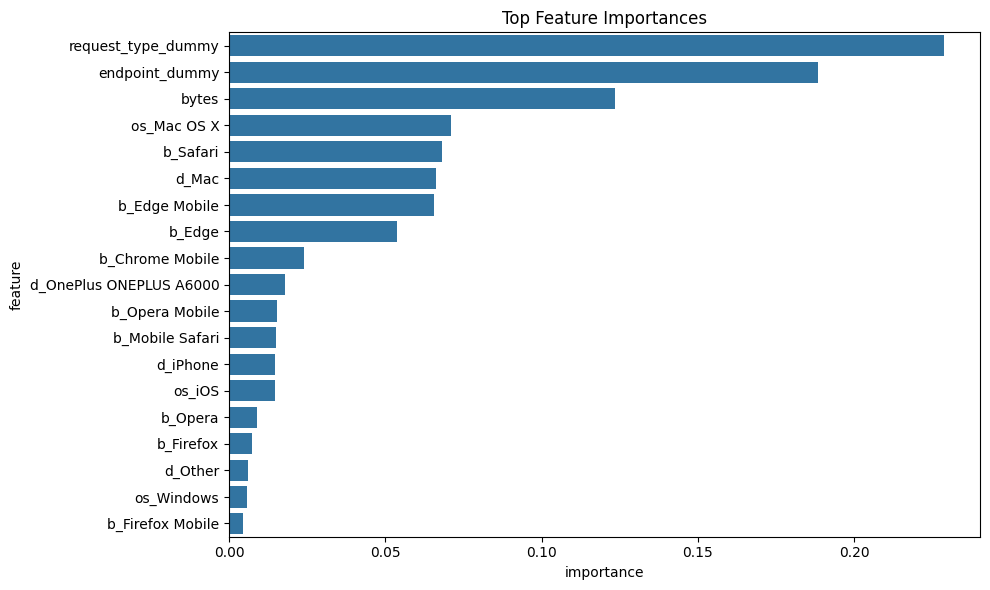

In [ ]:
importances = model_best.feature_importances_
feature_names = X.columns

# Sort and visualize
feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance_df.head(30), x='importance', y='feature')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()